In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
import pymc as pm

from datetime import datetime
from tqdm.notebook import tqdm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
surface_df_path = "data/clean_daylight_surface_ts.csv"

In [3]:
raw_df = pd.read_csv(surface_df_path)
raw_df["date_time"] = pd.to_datetime(raw_df["date_time"])
raw_df["plant_num"] = raw_df["plant_num"].astype(str)
raw_df["date"] = raw_df["date_time"].dt.normalize()
raw_df

,img_name,plant_num,date_time,surface,date
0,lettuce1_2024-06-15_07.jpg,1,2024-06-15 07:00:00,0.000000,2024-06-15
1,lettuce1_2024-06-15_08.jpg,1,2024-06-15 08:00:00,0.000000,2024-06-15
2,lettuce1_2024-06-15_09.jpg,1,2024-06-15 09:00:00,0.000000,2024-06-15
3,lettuce1_2024-06-15_10.jpg,1,2024-06-15 10:00:00,0.000000,2024-06-15
4,lettuce1_2024-06-15_11.jpg,1,2024-06-15 11:00:00,0.000000,2024-06-15
...,...,...,...,...,...
5499,lettuce8_2024-07-26_12.jpg,8,2024-07-26 12:00:00,281.915085,2024-07-26
5500,lettuce8_2024-07-26_13.jpg,8,2024-07-26 13:00:00,281.886747,2024-07-26
5501,lettuce8_2024-07-26_14.jpg,8,2024-07-26 14:00:00,280.357834,2024-07-26
5502,lettuce8_2024-07-26_15.jpg,8,2024-07-26 15:00:00,281.198534,2024-07-26


In [4]:
def plot_ts(x, y, df, hue=None):
    fig = plt.figure(figsize=(12, 6))

    if hue:
        sns.lineplot(x=x, y=y, data=df, hue=hue)
    else:
        sns.lineplot(x=x, y=y, data=df)
    plt.xlabel('Date Time')
    plt.ylabel('Surface cm2')
    plt.title('Plant surface cm2 over time')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()

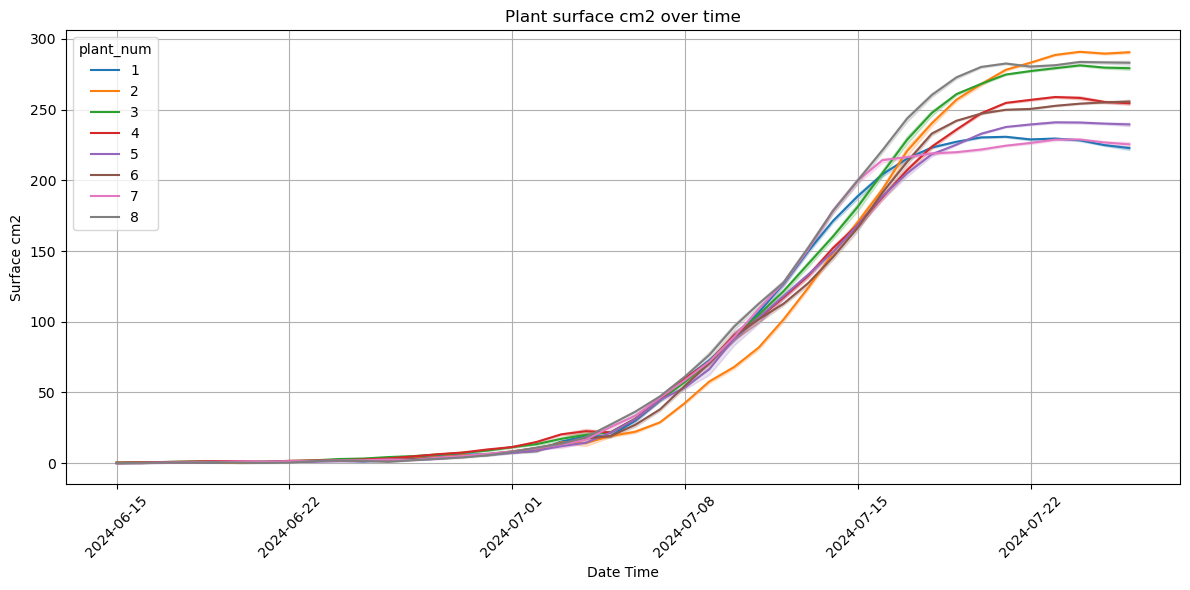

In [5]:
plot_ts(x="date", y="surface", df=raw_df, hue="plant_num")

In [10]:
df = raw_df.groupby(["plant_num", "date"])["surface"].mean().reset_index()
df["days_from_start"] = (df["date"] - df.groupby('plant_num')["date"].transform('min')).dt.days
mean_df = df.groupby("days_from_start")["surface"].mean().sort_index().reset_index()
df.head()

,plant_num,date,surface,days_from_start
0,1,2024-06-15,0.000000,0
1,1,2024-06-16,0.158717,1
2,1,2024-06-17,0.340680,2
3,1,2024-06-18,0.523646,3
4,1,2024-06-19,0.351673,4


In [53]:
train_plants = ["1", "2", "3", "4", "5", "6"]
test_plants = ["7", "8"]

train_df = df[df["plant_num"].isin(train_plants)]
test_df7 = df[df["plant_num"] == test_plants[0]]
test_df8 = df[df["plant_num"] == test_plants[1]]

### PyMC 

In [22]:
# Let's define the sigmoid function
def sigmoid(t, A, k, t0):
    return A / (1 + np.exp(-k * (t - t0)))

# PyMC Model
def train_model(df, A_mu=250, A_sigma=50, k_mu=1.0, k_sigma=0.5, t0_mu=20, t0_sigma=5):
    with pm.Model() as model:
        # Priors for parameters A, k, t0
        A = pm.Normal('A', mu=A_mu, sigma=A_sigma)  # Prior for max surface area
        k = pm.Normal('k', mu=k_mu, sigma=k_sigma) # Prior for growth rate
        t0 = pm.Normal('t0', mu=t0_mu, sigma=t0_sigma)  # Prior for inflection point (mid of growth)
    
        # Expected sigmoid growth for each day
        day_data = df["days_from_start"].values
        growth_curve = sigmoid(day_data, A, k, t0)
    
        # Likelihood (observed data)
        surface_data = df["surface"].values
        sigma = pm.HalfNormal('sigma', sigma=10)  # Error term
        likelihood = pm.Normal('surface', mu=growth_curve, sigma=sigma, observed=surface_data)
    
        # Inference
        trace = pm.sample(1000, tune=1000, return_inferencedata=True)
        return trace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, k, t0, sigma]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


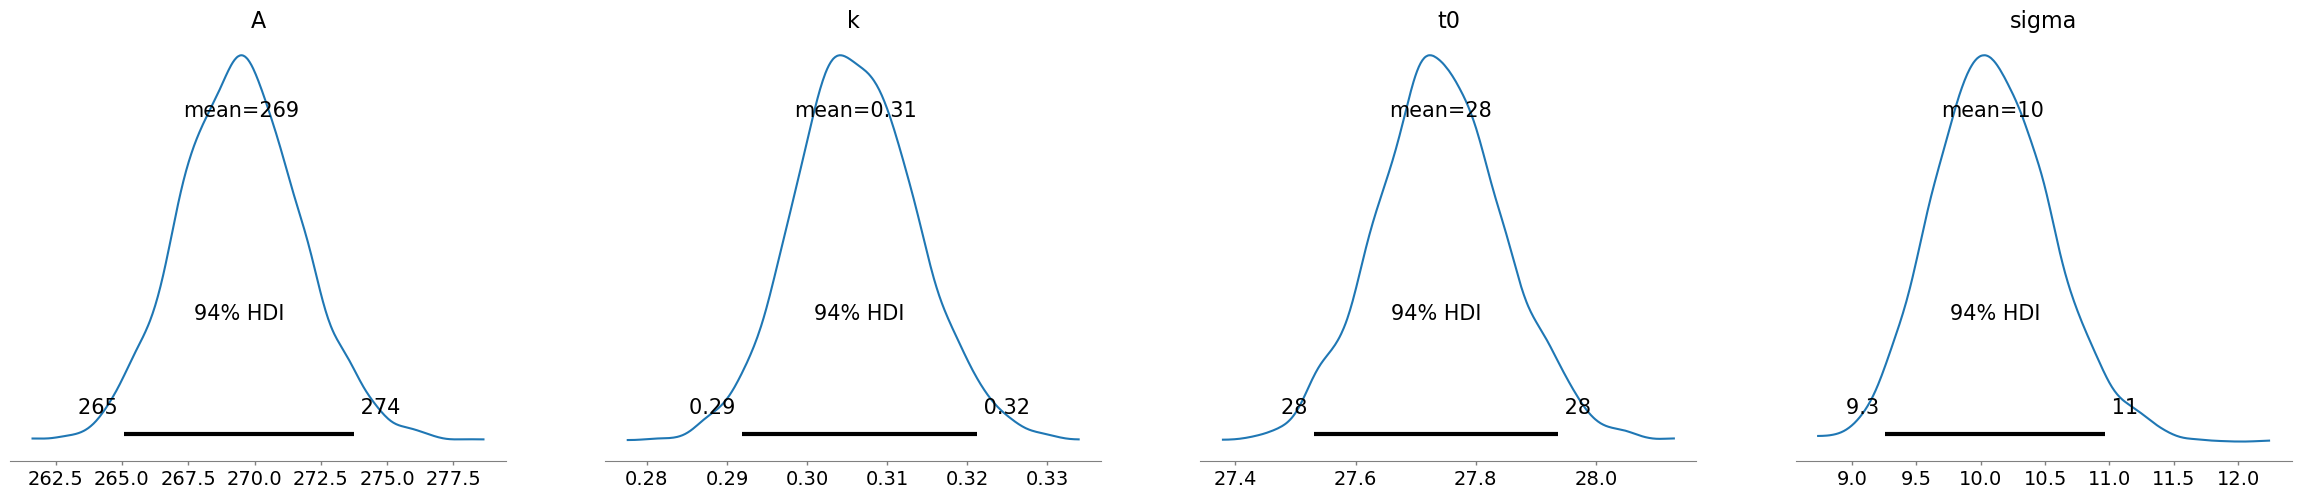

In [24]:
trace = train_model(train_df)
pm.plot_posterior(trace)
plt.show()

In [49]:
def plot_plant_growth(trace, x_line=None, y_line=None, label_line=None,
                      x_line2=None, y_line2=None, label_line2=None,
                      x_scatter=None, y_scatter=None, label_scatter=None):
    days = np.arange(0, 41)
    
    # Extract posterior samples
    A_samples = trace.posterior['A'].values.flatten()  # Flatten the multidimensional arrays
    k_samples = trace.posterior['k'].values.flatten()
    t0_samples = trace.posterior['t0'].values.flatten()
    
    # Initialize an array to store growth curves
    growth_curves = np.zeros((len(A_samples), len(days)))
    
    # Compute the growth curve for each sample
    for i in range(len(A_samples)):
        growth_curves[i, :] = sigmoid(days, A_samples[i], k_samples[i], t0_samples[i])
    
    # Compute the mean, 2.5th, and 97.5th percentiles for each day (to get 95% CI)
    mean_growth = np.mean(growth_curves, axis=0)
    ci_lower = np.percentile(growth_curves, 2.5, axis=0)
    ci_upper = np.percentile(growth_curves, 97.5, axis=0)
    
    # Plot the mean and the 95% confidence interval
    plt.figure(figsize=(10, 6))
    plt.plot(days, mean_growth, label='Mean Growth Curve', color='blue')
    plt.fill_between(days, ci_lower, ci_upper, color='blue', alpha=0.3, label='95% Confidence Interval')
    if not x_line is None and not y_line is None:
        plt.plot(x_line, y_line, label=label_line, color="red")
    if not x_scatter is None and not y_scatter is None:
        plt.scatter(x=x_scatter, y=y_scatter, label=label_scatter, color="red")
    if not x_line2 is None and not y_line2 is None:
        plt.plot(x_line2, y_line2, label=label_line2, color="green")
    plt.xlabel('Days from start')
    plt.ylabel('Surface Area (cm²)')
    plt.title('Predicted Plant Growth with 95% Confidence Interval')
    plt.legend()
    plt.grid(True)
    plt.show()

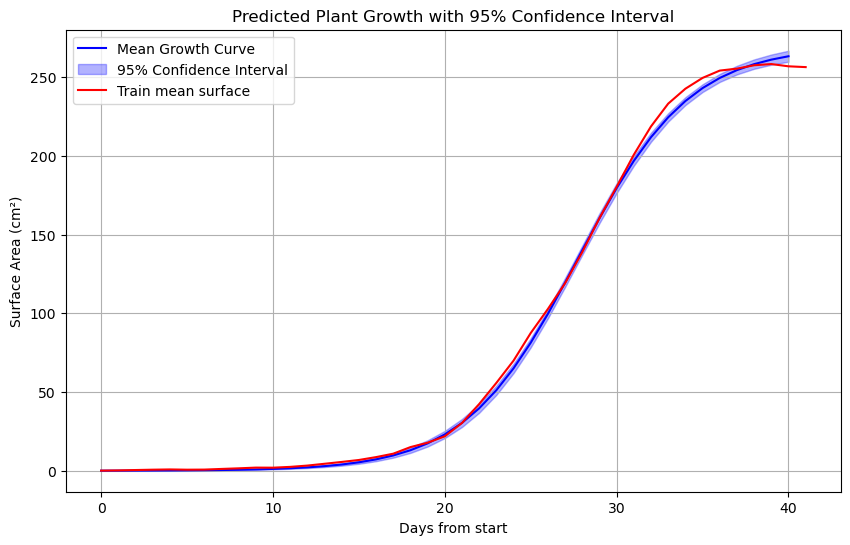

In [52]:
plot_plant_growth(trace, x_line=mean_df["days_from_start"], y_line=mean_df["surface"], label_line="Train mean surface")

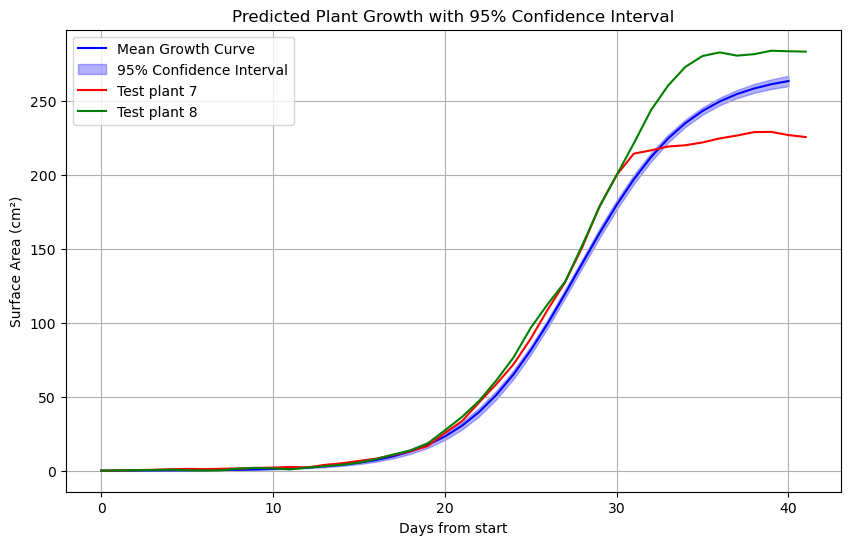

In [51]:
plot_plant_growth(trace, x_line=test_df8["days_from_start"], y_line=test_df8["surface"], label_line="Test plant 7",
                 x_line2=test_df8["days_from_start"], y_line2=test_df8["surface"], label_line2="Test plant 8")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, k, t0, sigma]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
There were 185 divergences after tuning. Increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


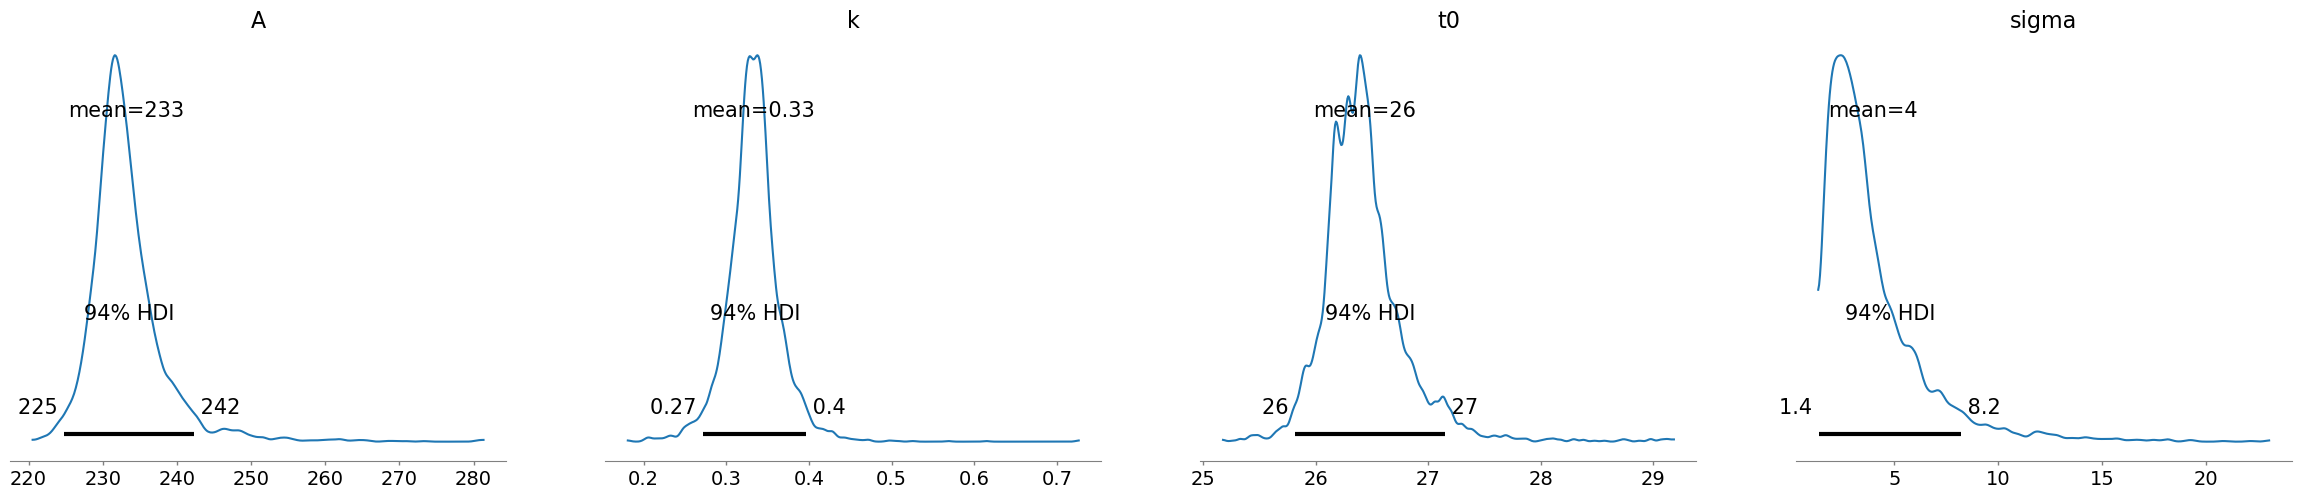

In [56]:
test_days = [10, 15, 20, 25, 35, 40]
test_points = test_df7[test_df7["days_from_start"].isin(test_days)]

# Use posterior distributions to create prior for test adjustments
# For adjusting based on new test points
trace_adj = train_model(test_points, 
                        A_mu=trace.posterior['A'].mean().values, A_sigma=20,
                        k_mu=trace.posterior['k'].mean().values, k_sigma=0.3,
                        t0_mu=trace.posterior['t0'].mean().values, t0_sigma=3)

# Plot adjusted growth curve
pm.plot_posterior(trace_adj)
plt.show()

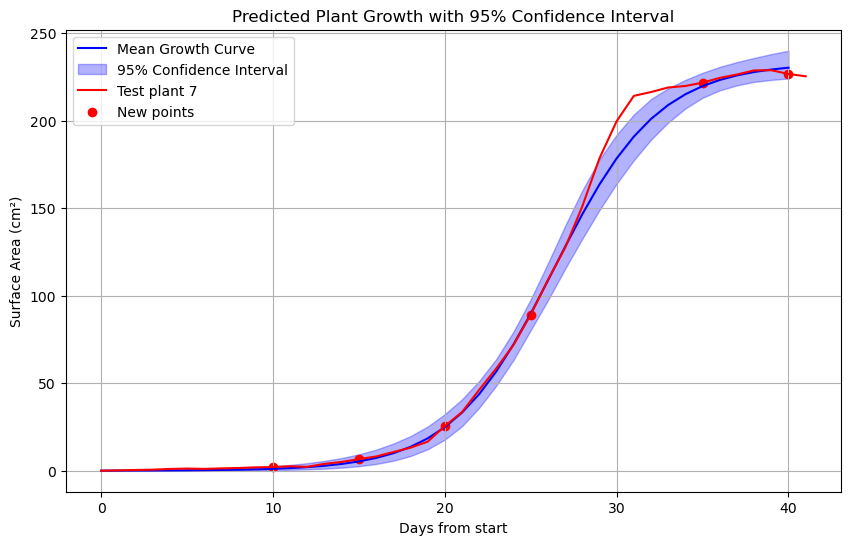

In [59]:
plot_plant_growth(trace_adj, x_line=test_df7["days_from_start"], y_line=test_df7["surface"], label_line="Test plant 7",
                  x_scatter=test_points["days_from_start"], y_scatter=test_points["surface"], label_scatter="New points")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, k, t0, sigma]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


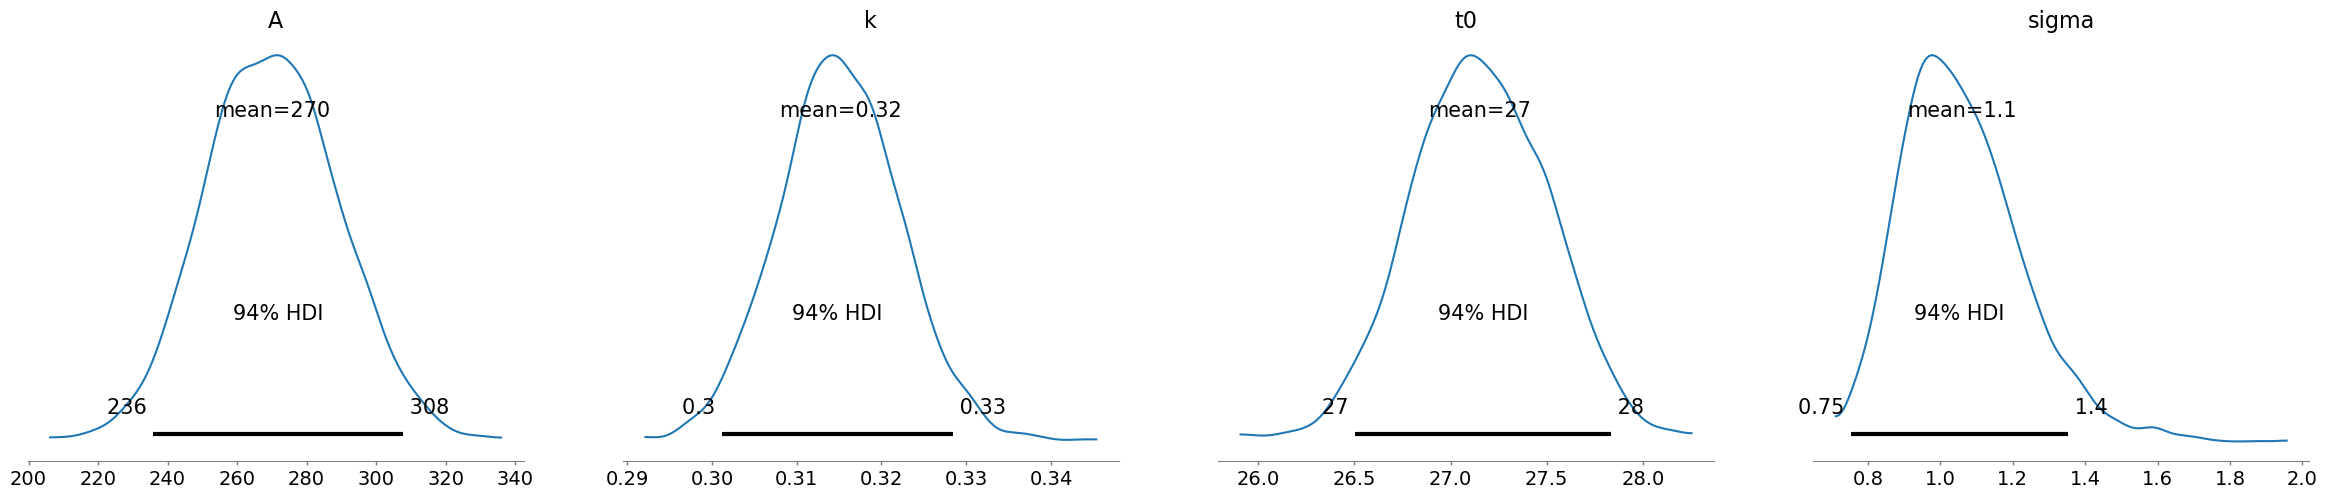

In [60]:
test_days = list(range(25))
test_points = test_df7[test_df7["days_from_start"].isin(test_days)]

# Use posterior distributions to create prior for test adjustments
# For adjusting based on new test points
trace_adj = train_model(test_points, 
                        A_mu=trace.posterior['A'].mean().values, A_sigma=20,
                        k_mu=trace.posterior['k'].mean().values, k_sigma=0.3,
                        t0_mu=trace.posterior['t0'].mean().values, t0_sigma=3)

# Plot adjusted growth curve
pm.plot_posterior(trace_adj)
plt.show()

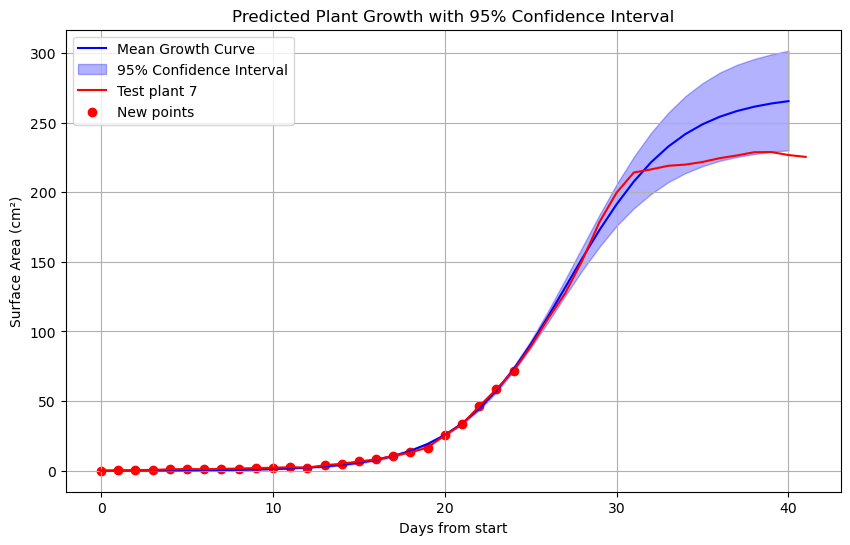

In [61]:
plot_plant_growth(trace_adj, x_line=test_df7["days_from_start"], y_line=test_df7["surface"], label_line="Test plant 7",
                  x_scatter=test_points["days_from_start"], y_scatter=test_points["surface"], label_scatter="New points")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, k, t0, sigma]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
There were 232 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


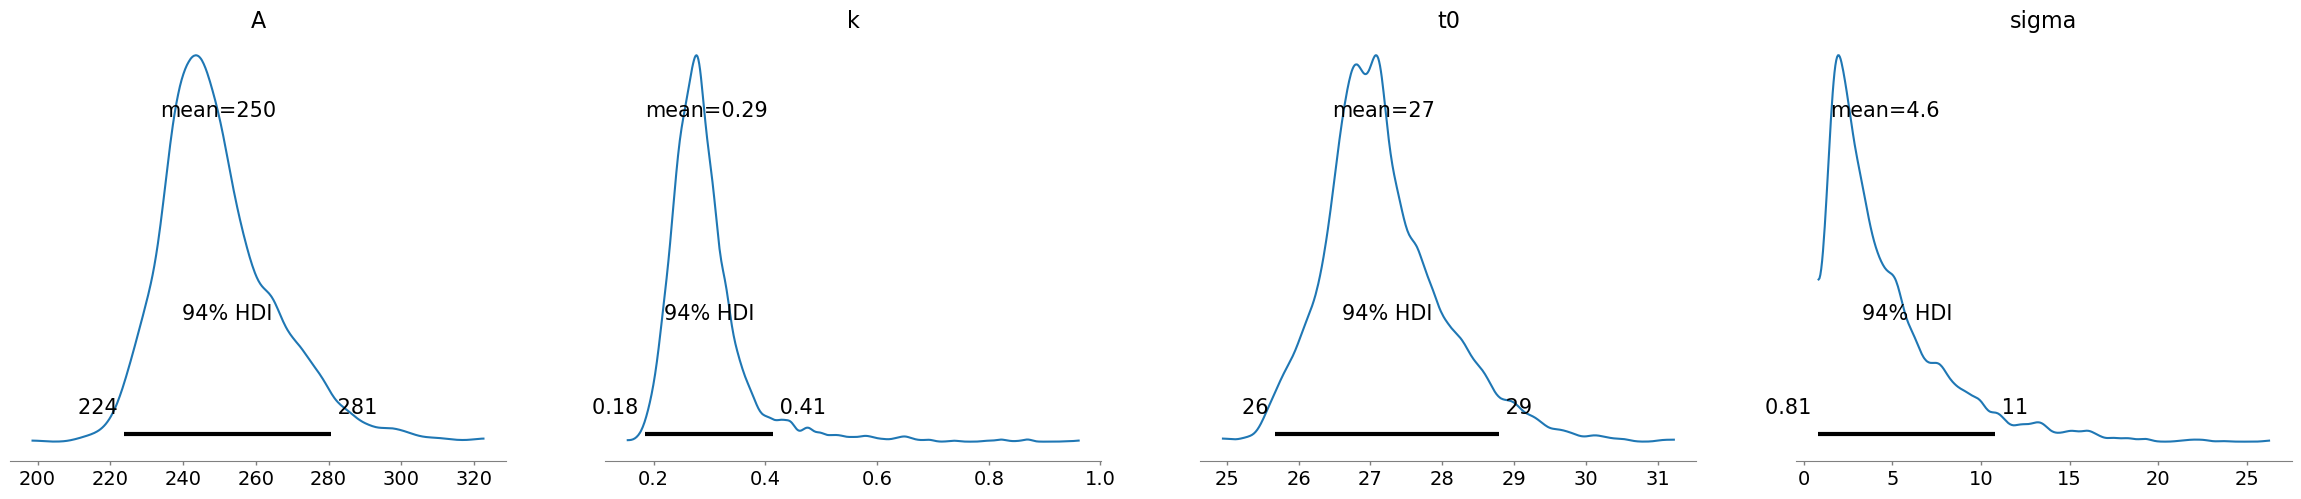

In [64]:
test_days = [5, 15, 25, 35]
test_points = test_df7[test_df7["days_from_start"].isin(test_days)]

# Use posterior distributions to create prior for test adjustments
# For adjusting based on new test points
trace_adj = train_model(test_points, 
                        A_mu=trace.posterior['A'].mean().values, A_sigma=20,
                        k_mu=trace.posterior['k'].mean().values, k_sigma=0.3,
                        t0_mu=trace.posterior['t0'].mean().values, t0_sigma=3)

# Plot adjusted growth curve
pm.plot_posterior(trace_adj)
plt.show()

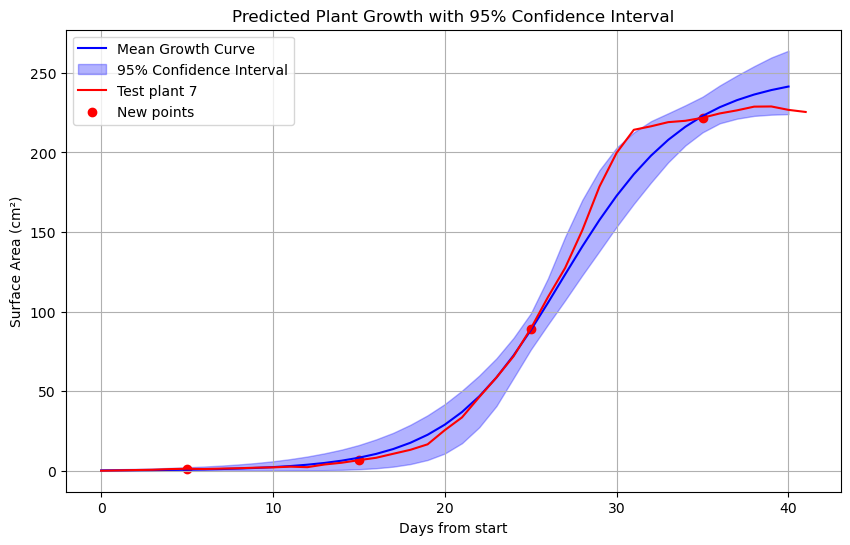

In [65]:
plot_plant_growth(trace_adj, x_line=test_df7["days_from_start"], y_line=test_df7["surface"], label_line="Test plant 7",
                  x_scatter=test_points["days_from_start"], y_scatter=test_points["surface"], label_scatter="New points")